In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

# Combine phase M and G2 into one class
df['phase'] = df['phase'].replace({'M': 'G2'})

le = LabelEncoder()
df['phase'] = le.fit_transform(df['phase']) 

# Separate features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])
y = df['phase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949, stratify=y)

In [3]:
# Initialize XGBoost Regressor
xgb_model = XGBClassifier(
    n_estimators=500,
    eta = 0.3,
    max_depth=50,
    tree_method = "hist",
    random_state=949
)

In [8]:
## hypertuning

param_grid = {
    'n_estimators': [600],              
    'max_depth': [20, 30, 40],
    'eta': [0.05]          
}

# Set up GridSearch with 10-fold cross-validation optimizing for accuracy
grid_search = GridSearchCV(
    estimator= xgb_model,
    param_grid=param_grid,
    cv=10,
    scoring= 'accuracy',
    n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X_train, y_train)

#Output best settings and best accuracy
print("Best parameters:", grid_search.best_params_)
#print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'eta': 0.05, 'max_depth': 20, 'n_estimators': 600}


In [4]:
# retrain model
xgb_model = XGBClassifier(
    n_estimators=500,
    eta = 0.05,
    max_depth=20,
    tree_method = "hist",
    random_state=949
)

In [5]:
xgb_model.fit(X_train, y_train)

# Predict
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [15]:
y_train_labels = le.inverse_transform(y_train)
y_test_labels = le.inverse_transform(y_test)
y_train_pred_labels = le.inverse_transform(y_train_pred)
y_test_pred_labels = le.inverse_transform(y_test_pred)

# Output results
print("=== Training Set ===")
print("Overall Accuracy:", accuracy_score(y_train_labels, y_train_pred_labels))

print("\n=== Test Set ===")
print("Overall Accuracy:", accuracy_score(y_test_labels, y_test_pred_labels))

# Accuracy per phase (Train)
df_train = pd.DataFrame({'true': y_train_labels, 'pred': y_train_pred_labels})
accuracy_per_phase_train = df_train.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))

print("Accuracy per phase (Train):")
print(accuracy_per_phase_train)

# Accuracy per phase (Test)
df_test = pd.DataFrame({'true': y_test_labels, 'pred': y_test_pred_labels})
accuracy_per_phase_test = df_test.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))

print("\nAccuracy per phase (Test):")
print(accuracy_per_phase_test)

# Confusion Matrix
print("\nTest Confusion Matrix")
print(confusion_matrix(y_test_labels, y_test_pred_labels, labels=["G0", "G1", "G2", "S"]))

=== Training Set ===
Overall Accuracy: 1.0

=== Test Set ===
Overall Accuracy: 0.976271186440678
Accuracy per phase (Train):
true
G0    1.0
G1    1.0
G2    1.0
S     1.0
dtype: float64

Accuracy per phase (Test):
true
G0    1.000000
G1    0.973186
G2    0.966387
S     0.967619
dtype: float64

Test Confusion Matrix
[[373   0   0   0]
 [  0 617   0  17]
 [  0   0 230   8]
 [  0   9   8 508]]


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_72687/4154681254.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_phase_train = df_train.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_72687/4154681254.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_phase_test = df_test.groupby('true').apply(

                         Normalized Weight
Feature                                   
E2F1..nuc.median.                 0.060602
p21..phospho.total.nuc.           0.045766
Int_Intg_DNA_nuc                  0.039168
cycA..nuc.median.                 0.038714
PCNA..nuc.median.                 0.037283
...                                    ...
p27..cyto.median.                 0.000489
CDK2..cell.median.                0.000454
pp21..cell.median.                0.000384
p38..cell.median.                 0.000244
p53..cell.median.                 0.000140

[209 rows x 1 columns]


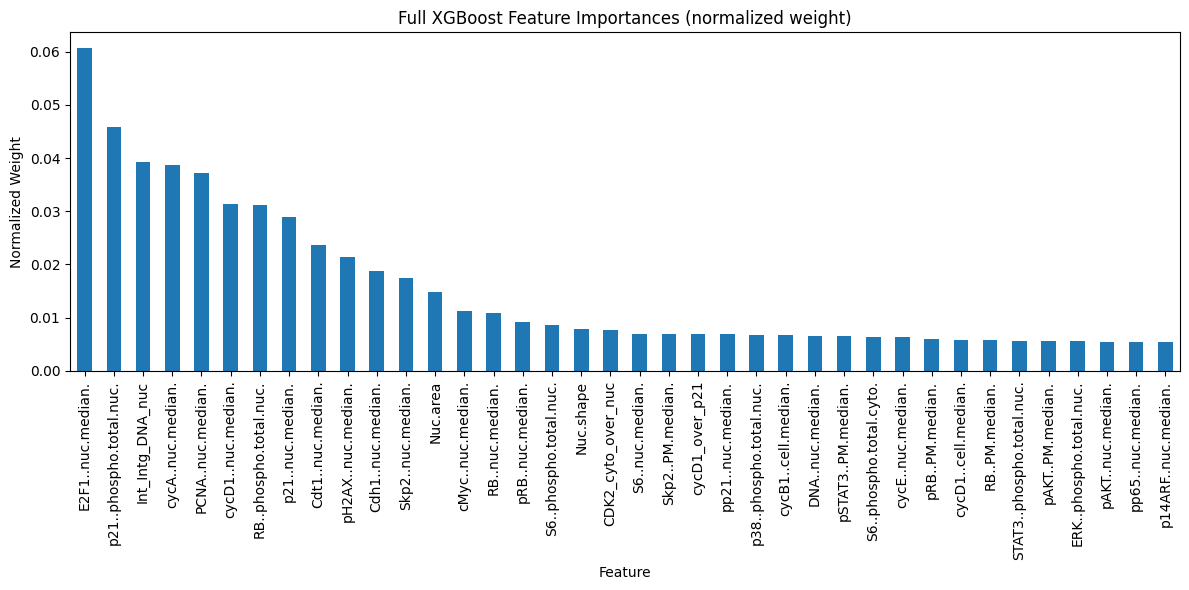

In [14]:
# MDI feature ranking (weight)
booster = xgb_model.get_booster()

# Get importance by "weight" (~ MDI)
importance_dict = booster.get_score(importance_type='weight')

# Normalize to sum to 1
total = sum(importance_dict.values())
normalized_scores = {k: v / total for k, v in importance_dict.items()}


importance_df = pd.DataFrame.from_dict(normalized_scores, orient='index', columns=['Normalized Weight'])
importance_df.index.name = 'Feature'
importance_df = importance_df.sort_values(by='Normalized Weight', ascending=False)
print(importance_df)

# Select top 40 for plotting
top_n = 38
top_features_df = importance_df.head(top_n)

# Plot
top_features_df.plot(kind='bar', figsize=(12, 6), legend=False)
plt.title(f"Full XGBoost Feature Importances (normalized weight)")
plt.ylabel("Normalized Weight")
plt.xlabel("Feature")
plt.tight_layout()
# Save the plot
plot_path = "xgb_classification_important_full.png"
plt.savefig(plot_path, dpi=300)
plt.show()